# GridSelection Degrader to Emulate HSC Training Samples

last run successfully: April 26, 2023

The GridSelection degrader can be used to model the spectroscopic success rates in training sets based on real data.  Given a 2-dimensional grid of spec-z success ratio as a function of two variables (often magnitude or color), the degrader will draw the appropriate fraction of samples from the input data and return a sample with incompleteness modeled.  An additional redshift cut can also be applied, where all redshifts above the cutoff are also removed from the sample.

The degrader takes the following arguments:
- `ratio_file`: the name of the file containing the 2-dimensional grid of spec-z success <br>
- `random_seed`: random seed to feed to numpy for reproducibility<br>
- `settings_file`: path to the pickled file containing settings that define the 2-dimensional grid.  There is a mechanism to make cuts either on a single column from the input data, or a difference (i.e. either a magnitude or a color as a difference of two magnitudes). The parameters in the settings file are:<br>
  - `x_band_1`: column name for the x-axis variable from ratios grid.  
  - `x_band_2`: [optional] column name for the second x-axis variable.  If x_band_2 is set to '' then it is assumed that the x-axis is parameterized in terms of x_band_1.  If x_band_2 is not '' then the x-axis is compared against (x_band_1 - x_band_2)
  -`y_band_1` and `y_band_2`: analagous to `x_band_1` and `x_band_2` but for the y-axis
  - `x_limits` and `y_limits`: 2-element lists with the minimum and maximum values for the grid, e.g. [13, 26] if the limits in the x-axis are between magnitudes of 13 and 26.

In this quick notebook we'll create a grid of mock galaxies on the same grid on which the HyperSuprimeCam Survey (HSC) spectroscopic success has been parameterized by Irene Moskowitz (and available in the rail_base repository at `rail_base/src/rail/examples_data/creation_data/`), and plot the success rate to visualize the spectroscopic success rate for HSC.

**Note:** If you're planning to run this in a notebook, you may want to use interactive mode instead. See [`GridSelection_for_HSC.ipynb`](https://github.com/LSSTDESC/rail/blob/main/interactive_examples/creation_examples/GridSelection_for_HSC.ipynb) in the `interactive_examples/creation_examples/` folder for a version of this notebook in interactive mode.

In [1]:
import rail
import os
import matplotlib.pyplot as plt
import numpy as np
import tables_io
import pandas as pd
#from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.utils.path_utils import find_rail_file
%matplotlib inline 

Let's make a grid of fake data matching the grid used by HSC.  The 2D grid of spec-z success in this case is parameterized in terms of `g-z` color vs `i-band` magnitude, with `g-z` between `[-2, 6]` and `i-band` magnitude spanning `[13, 26]`.  Let's generate 100 identical objects in each of the 100x100=10,000 grid cells, for a total of 1,000,000 mock galaxies.  The only quantities that we need are `g`, `i`, `z` magnitudes and a `redshift` that we can just set to a random number between 1 and 2.5.  The only thing that we really need is consistent g-z and i-mag values, so we can just set g to 20.0 in all circumstances.

In [2]:
gridgz, gridi = np.meshgrid(np.linspace(-1.98, 5.98, 100), np.linspace(13.0325, 25.9675, 100))

In [3]:
i = gridi.flatten()
gz = gridgz.flatten()
g = np.full_like(i, 20.0, dtype=np.double)
z = g - gz
redshift = np.round(np.random.uniform(size=len(i))*2.5, 2)

In [4]:
mockdict = {}
for label, item in zip(['i', 'gz', 'g', 'z', 'redshift'], [i, gz, g, z, redshift]):
    mockdict[f'{label}'] = np.repeat(item, 100).flatten()

In [5]:
df = pd.DataFrame(mockdict)

In [6]:
df.head()

,i,gz,g,z,redshift
0,13.0325,-1.98,20.0,21.98,1.31
1,13.0325,-1.98,20.0,21.98,1.31
2,13.0325,-1.98,20.0,21.98,1.31
3,13.0325,-1.98,20.0,21.98,1.31
4,13.0325,-1.98,20.0,21.98,1.31


Now, let's import the GridSelection degrader and set up the config dict parameters.  We will set a redshift cut of 5.1 so as to not cut any of our mock galaxies, if you would want a redshift cut, you would simply change this parameter as desired.  There is an optional `color_redshift_cut` that scales the number of galaxies kept, we will turn this off.  There is also a `percentile_cut` that computes percentiles in redshift of each cell and removes the highest redshift galaxies, as those are usually the most likely to not be recovered by a spectroscopic survey.  For simplicity, we will set percentile_cut to 100. to not remove any galaxies with this cut.

The ratio file for HSC is located in the `RAIL/examples/creation/data` directory, as we are in `RAIL/examples/creation` folder with this demo the paths for the `ratio_file` and `settings_file` are set accordingly.

We will set a random seed for reproducibility, and set the output file to write our incomplete catalog to "test_hsc.pq".

In [7]:
from rail.creation.degraders.grid_selection import GridSelection

In [8]:
configdict = dict(redshift_cut=5.1, 
                  ratio_file=find_rail_file('examples_data/creation_data/data/hsc_ratios_and_specz.hdf5'),
                  settings_file=find_rail_file('examples_data/creation_data/data/HSC_grid_settings.pkl'),
                  percentile_cut=100.,
                  color_redshift_cut=False,
                  output="test_hsc.pq", random_seed=66)

In [9]:
hsc_selecter = GridSelection.make_stage(name='hsc_cutter', **configdict)

Let's run the code and see how long it takes:

In [10]:
%%time
trim_data = hsc_selecter(df)

Inserting handle into data store.  input: None, hsc_cutter
Inserting handle into data store.  output_hsc_cutter: inprogress_test_hsc.pq, hsc_cutter
CPU times: user 4.51 s, sys: 314 ms, total: 4.83 s
Wall time: 4.84 s


This took 10.1s on my home computer, not too bad for 4 million mock galaxies.

In [11]:
trim_data().info()

<class 'pandas.core.frame.DataFrame'>
Index: 181723 entries, 84300 to 927787
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   i          181723 non-null  float64
 1   gz         181723 non-null  float64
 2   g          181723 non-null  float64
 3   z          181723 non-null  float64
 4   redshift   181723 non-null  float64
 5   x_vals     181723 non-null  float64
 6   y_vals     181723 non-null  float64
 7   ratios     181723 non-null  float64
 8   max_specz  181723 non-null  float64
dtypes: float64(9)
memory usage: 13.9 MB


And we see that we've kept 625,677 out of the 4,000,000 galaxies in the initial sample, so about 15% of the initial sample.  To visualize our cuts, let's read in the success ratios file and plot our sample overlaid with an alpha of 0.01, that way the strength of the black dot will give a visual indication of how many galaxies in each cell we've kept.

In [12]:
# compare to sum of ratios * 100
ratio_file=find_rail_file('examples_data/creation_data/data/hsc_ratios_and_specz.hdf5')

In [13]:
allrats = tables_io.read(ratio_file)['ratios']

In [14]:
trim_data()['color'] = trim_data()['g'] - trim_data()['z']

/tmp/ipykernel_378414/1938339790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trim_data()['color'] = trim_data()['g'] - trim_data()['z']


In [15]:
bgr, bi = np.meshgrid(np.linspace(-2, 6, 101), np.linspace(13, 26, 101))

In [16]:
bratios = tables_io.read(find_rail_file('examples_data/creation_data/data/hsc_ratios_and_specz.hdf5'))['ratios']

Text(0, 0.5, 'g-i')

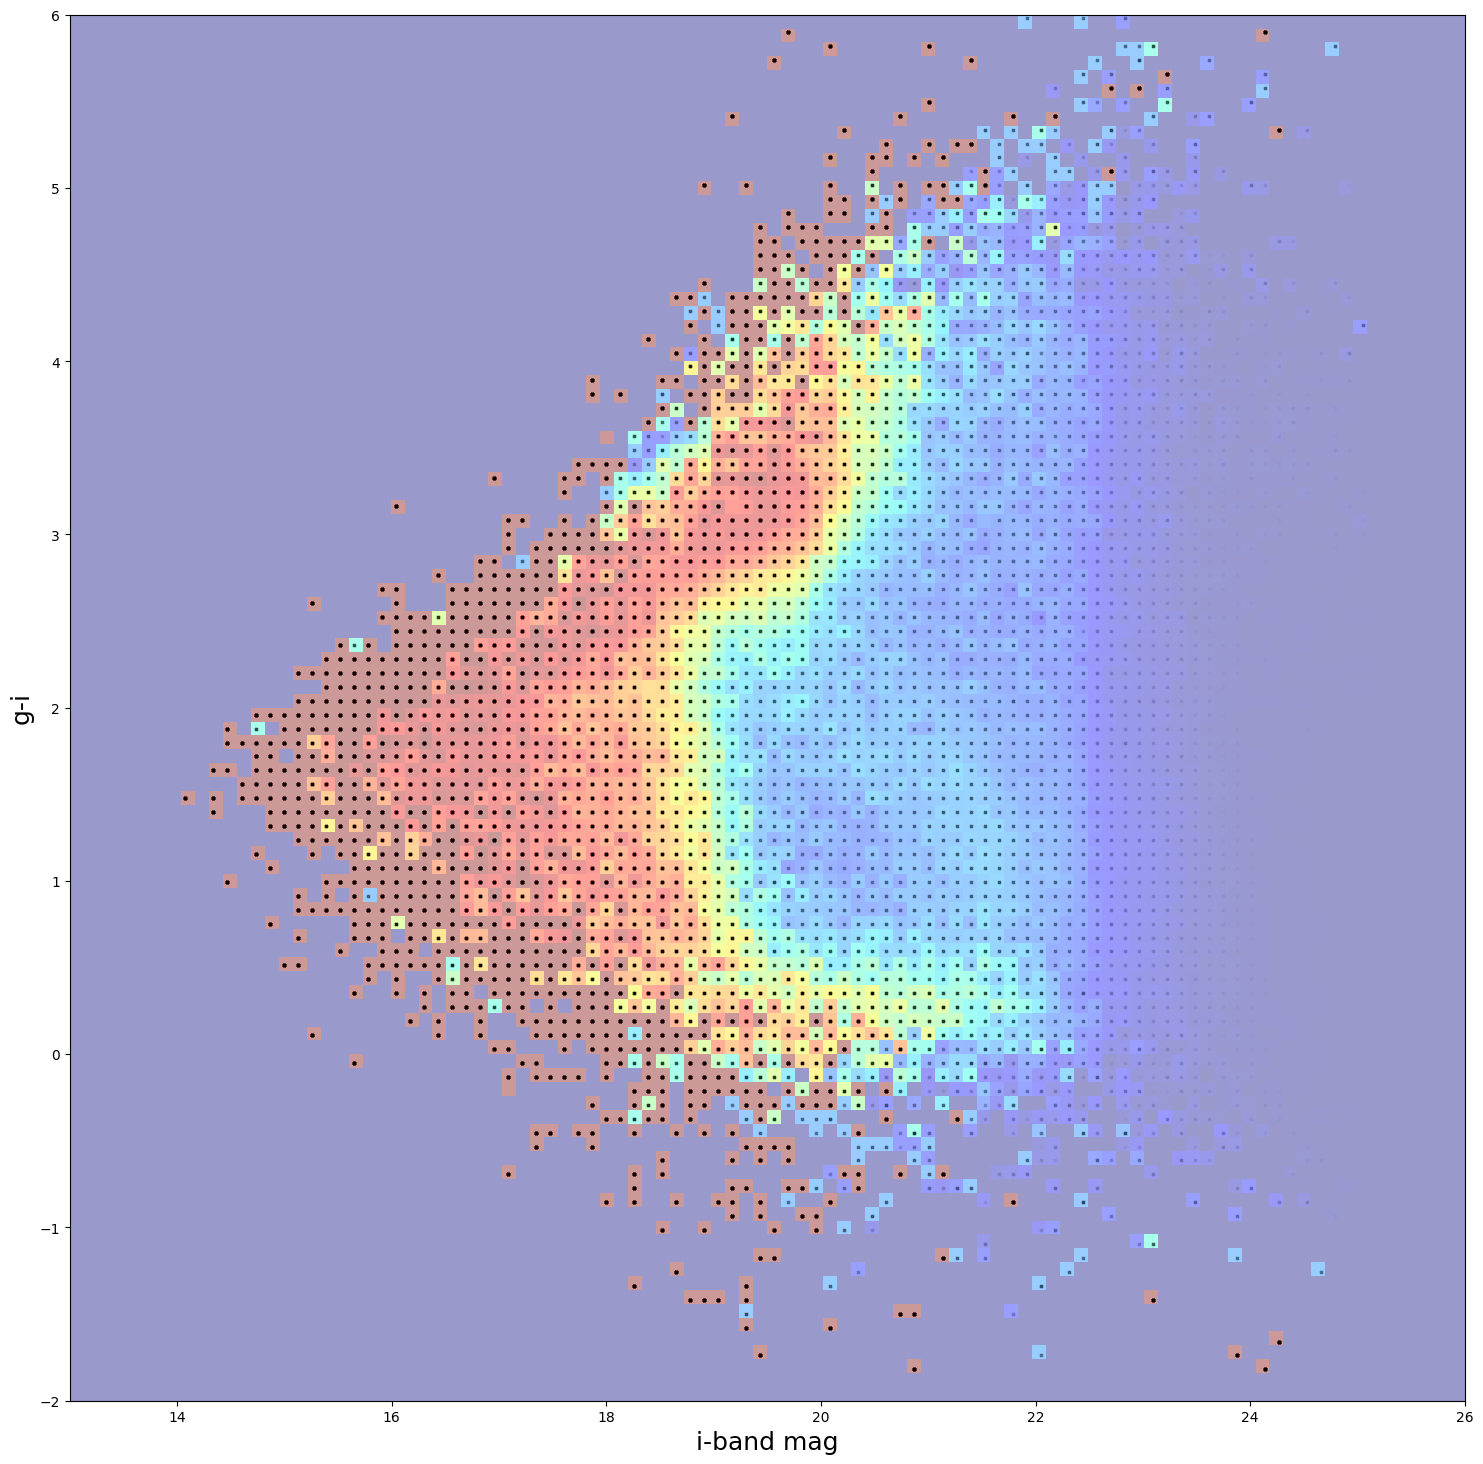

In [17]:
plt.figure(figsize=(18,18))
plt.pcolormesh(bi, bgr, bratios.T, cmap='jet', vmin=0, vmax=1,alpha=0.4)
plt.scatter(trim_data()['i'], trim_data()['color'], s=3, c='k',alpha =.015)
plt.xlabel("i-band mag", fontsize=18)
plt.ylabel("g-i", fontsize=18)

The colormap shows the HSC ratios and the strenth of the black dots shows how many galaxies were actually kept. We see perfect agreement between our predicted ratios and the actual number of galaxies kept, the degrader is functioning properly, and we see a nice visual representation of the resulting spectroscopic sample incompleteness.

As our demo data is just a grid of mock points, let's remove it so we do not leave a large file sitting around:


In [18]:
os.remove("./test_hsc.pq")